In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

# sklearn Regressor Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Data Preparation
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

# import Visualisation library
from tabulate import tabulate

import ta
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(
    'ignore', 'invalid value encountered in double_scalars')


# Discussion 1: Determine the best period (time) for model training.

In [2]:
# Set different start dates
start_dates = ['2012-03-01', '2013-03-01', '2014-03-01',
               '2015-03-01', '2016-03-01', '2017-03-01',
               '2018-03-01', '2019-03-01', '2020-03-01', '2021-03-01']

# Set end date for historical price data
end_date = '2023-03-01'

# Set empty lists to store evaluation metrics
r2_svr_train_list = []
r2_svr_test_list = []
mse_svr_train_list = []
mse_svr_test_list = []
mae_svr_train_list = []
mae_svr_test_list = []

r2_rfr_train_list = []
r2_rfr_test_list = []
mse_rfr_train_list = []
mse_rfr_test_list = []
mae_rfr_train_list = []
mae_rfr_test_list = []

for i, start_date in enumerate(start_dates):
    # Download historical price data from Yahoo Finance and store in a pandas DataFrame for each start date
    df = yf.download("GOOGL", start=start_date,
                     end=end_date, progress=False)

    # Create a new column for the dependent variable
    df['PriceAfterMonth'] = df['Close'].shift(-20)

    # Remove rows with missing values
    df.dropna(inplace=True)

    # Define the independent and dependent variables
    X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    y = df['PriceAfterMonth']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=30, shuffle=False)

    # Preprocess the data by scaling it
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Build SVR model
    svr_model = SVR(kernel='linear', C=10, gamma='auto')
    # Fit the SVR model with a constant term
    X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
    X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

    svr_model.fit(X_train_with_const, y_train)

    # # Build RFR model
    rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
    rfr_model.fit(X_train, y_train)

    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train_with_const)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test_with_const)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)
    
    r2_svr_train_list.append(r2_svr_train)
    mse_svr_train_list.append(mse_svr_train)
    mae_svr_train_list.append(mae_svr_train)

    r2_svr_test_list.append(r2_svr_test)
    mse_svr_test_list.append(mse_svr_test)
    mae_svr_test_list.append(mae_svr_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)
    
    r2_rfr_train_list.append(r2_rfr_train)
    mse_rfr_train_list.append(mse_rfr_train)
    mae_rfr_train_list.append(mae_rfr_train)
    r2_rfr_test_list.append(r2_rfr_test)
    mse_rfr_test_list.append(mse_rfr_test)
    mae_rfr_test_list.append(mae_rfr_test)

svr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    svr_row = [year, r2_svr_train_list[i], r2_svr_test_list[i], mse_svr_train_list[i],
            mse_svr_test_list[i], mae_svr_train_list[i], mae_svr_test_list[i]]
    svr_table.append(svr_row)

print("SVR Model")
print(tabulate(svr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))

rfr_table = []
for i in range(len(start_dates)):
    year = start_dates[i][:4]
    rfr_row = [year, r2_rfr_train_list[i], r2_rfr_test_list[i], mse_rfr_train_list[i],
            mse_rfr_test_list[i], mae_rfr_train_list[i], mae_rfr_test_list[i]]
    rfr_table.append(rfr_row)

print("RFR Model")
print(tabulate(rfr_table, headers=["Year", "R² (Train)", "R² (Test)",
      "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


SVR Model
╒════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│   Year │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│   2012 │     0.96974  │   0.761045  │        9.9096 │      83.1076 │       2.03668 │      7.16519 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2013 │     0.962801 │   0.715288  │       12.4786 │      92.4188 │       2.28266 │      7.45306 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2014 │     0.962696 │   0.698897  │       14.7285 │     103.957  │       2.53701 │      7.85802 │
├────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│   2015 │     0.965628 │   0.692666  │       16.6443 │     118.246  │  

Ans: SVR model is good with data starting from 2012, while RFR model is good with data starting from 2015. Overall, I will continue with Year 2015, since both model can perform prediction.

# Discussion 2: Determine how well can SVR & RFR model predict future stock price.

In [3]:
def evaluate_train_test(X_train, X_test):
    # Test the models and evaluate the performance metrics
    # Calculate evaluation metrics for SVR model
    y_svr_pred_train = svr_model.predict(X_train)
    r2_svr_train = r2_score(y_train, y_svr_pred_train)
    mse_svr_train = mean_squared_error(y_train, y_svr_pred_train)
    mae_svr_train = mean_absolute_error(y_train, y_svr_pred_train)

    y_svr_pred_test = svr_model.predict(X_test)
    r2_svr_test = r2_score(y_test, y_svr_pred_test)
    mse_svr_test = mean_squared_error(y_test, y_svr_pred_test)
    mae_svr_test = mean_absolute_error(y_test, y_svr_pred_test)

    # Calculate evaluation metrics for RFR model
    y_rfr_pred_train = rfr_model.predict(X_train)
    r2_rfr_train = r2_score(y_train, y_rfr_pred_train)
    mse_rfr_train = mean_squared_error(y_train, y_rfr_pred_train)
    mae_rfr_train = mean_absolute_error(y_train, y_rfr_pred_train)

    y_rfr_pred_test = rfr_model.predict(X_test)
    r2_rfr_test = r2_score(y_test, y_rfr_pred_test)
    mse_rfr_test = mean_squared_error(y_test, y_rfr_pred_test)
    mae_rfr_test = mean_absolute_error(y_test, y_rfr_pred_test)

    result_table = []

    svr_result = ["SVR", r2_svr_train, r2_svr_test, mse_svr_train,
                mse_svr_test, mae_svr_train, mae_svr_test]

    rfr_result = ["RFR", r2_rfr_train, r2_rfr_test, mse_rfr_train,
                mse_rfr_test, mae_rfr_train, mae_rfr_test]

    result_table.append(svr_result)
    result_table.append(rfr_result)

    print(tabulate(result_table, headers=["Model", "R² (Train)", "R² (Test)",
                                        "MSE (Train)", "MSE (Test)", "MAE (Train)", "MAE (Test)"], tablefmt="fancy_grid"))


## Base Model

In [4]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train, y_train)

RandomForestRegressor(random_state=10)

In [5]:
evaluate_train_test(X_train, X_test)

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692667 │      16.6443  │      118.246 │      2.75005  │      8.61792 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995668 │    0.701868 │       2.09756 │      114.706 │      0.979002 │      9.13135 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛


╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.543634 │       12.5206  │        2.81349 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.790053 │        5.75999 │        1.90385 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


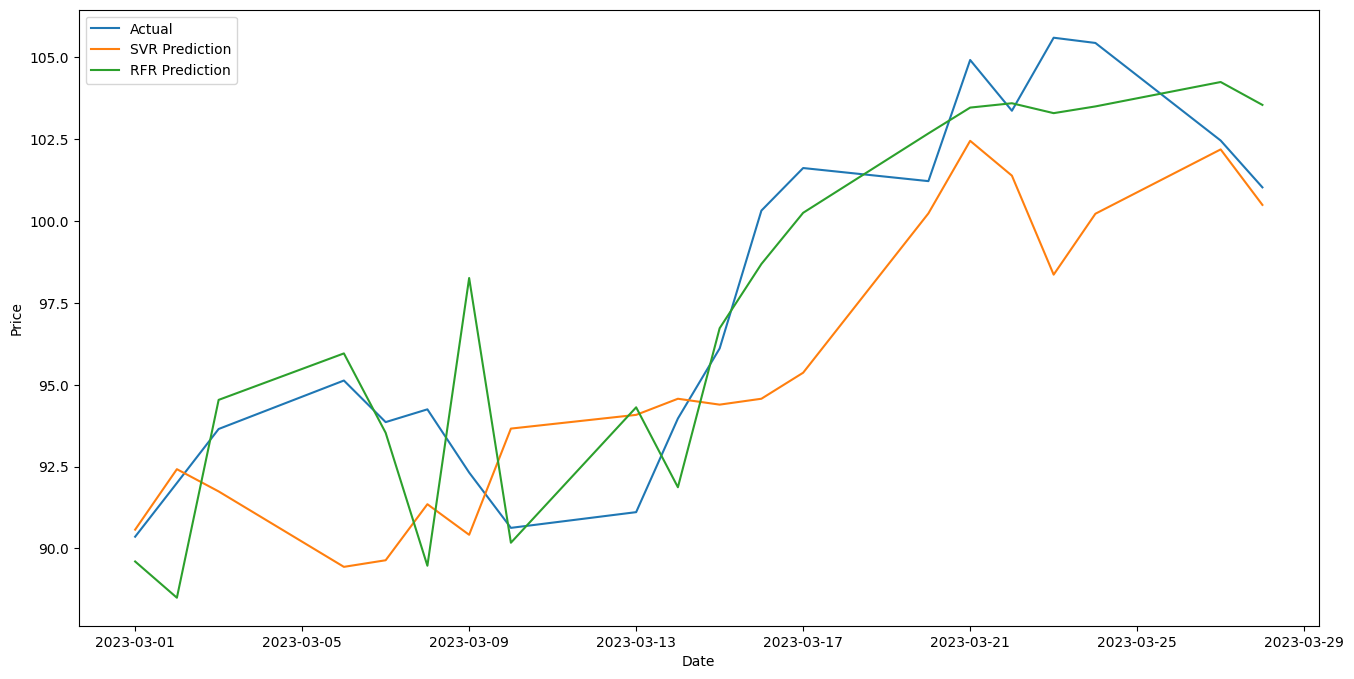

In [6]:
# Download latest 30 days historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred)
y_rfr_pred = rfr_model.predict(X_pred)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add constant

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965628 │    0.692666 │      16.6443  │      118.246 │      2.75005  │      8.61794 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995687 │    0.704123 │       2.08841 │      113.838 │      0.976529 │      9.07457 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.543639 │       12.5205  │        2.81348 │
├─────────┼───────────────┼────

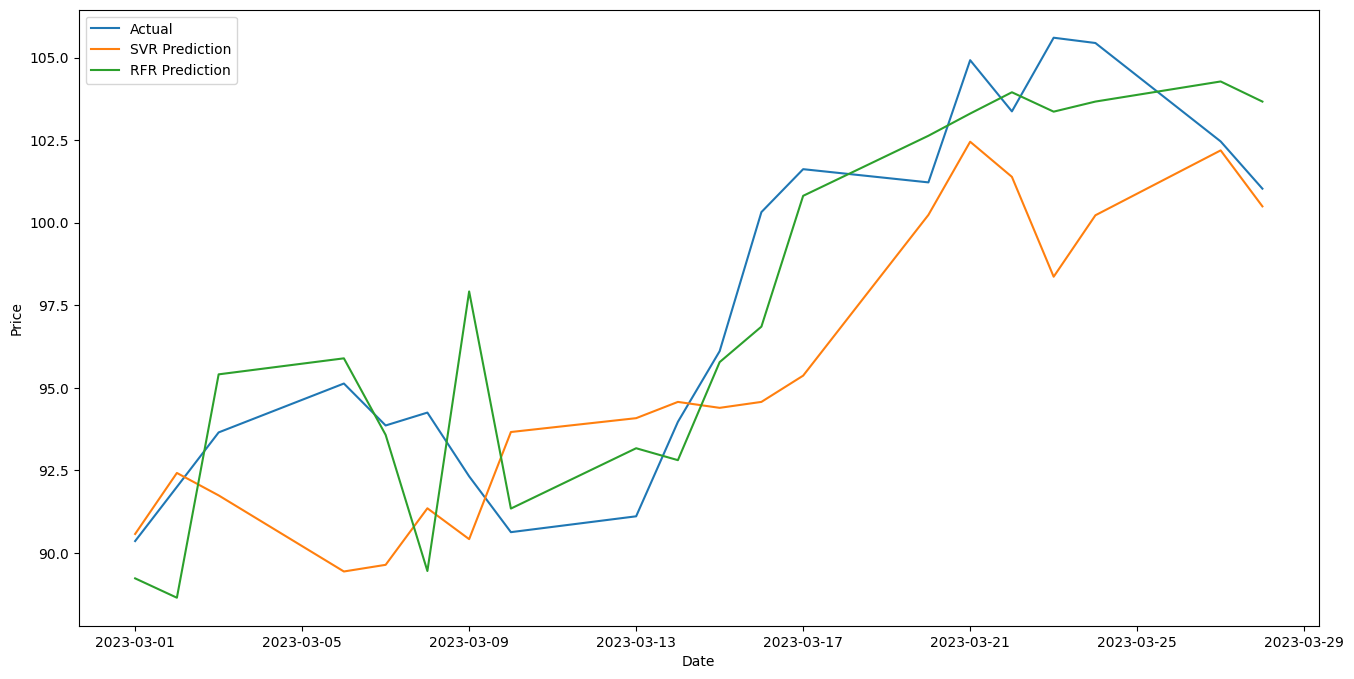

In [7]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_with_const, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_with_const, y_train)

evaluate_train_test(X_train_with_const, X_test_with_const)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_with_const)
y_rfr_pred = rfr_model.predict(X_pred_with_const)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


## Add Feature Selection using correlation coefficient


╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │       16.6461 │      118.915 │       2.75058 │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995461 │    0.710839 │        2.1982 │      111.254 │       1.00189 │      8.95766 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.54881  │       12.3786  │        2.79208 │
├─────────┼───────────────┼────

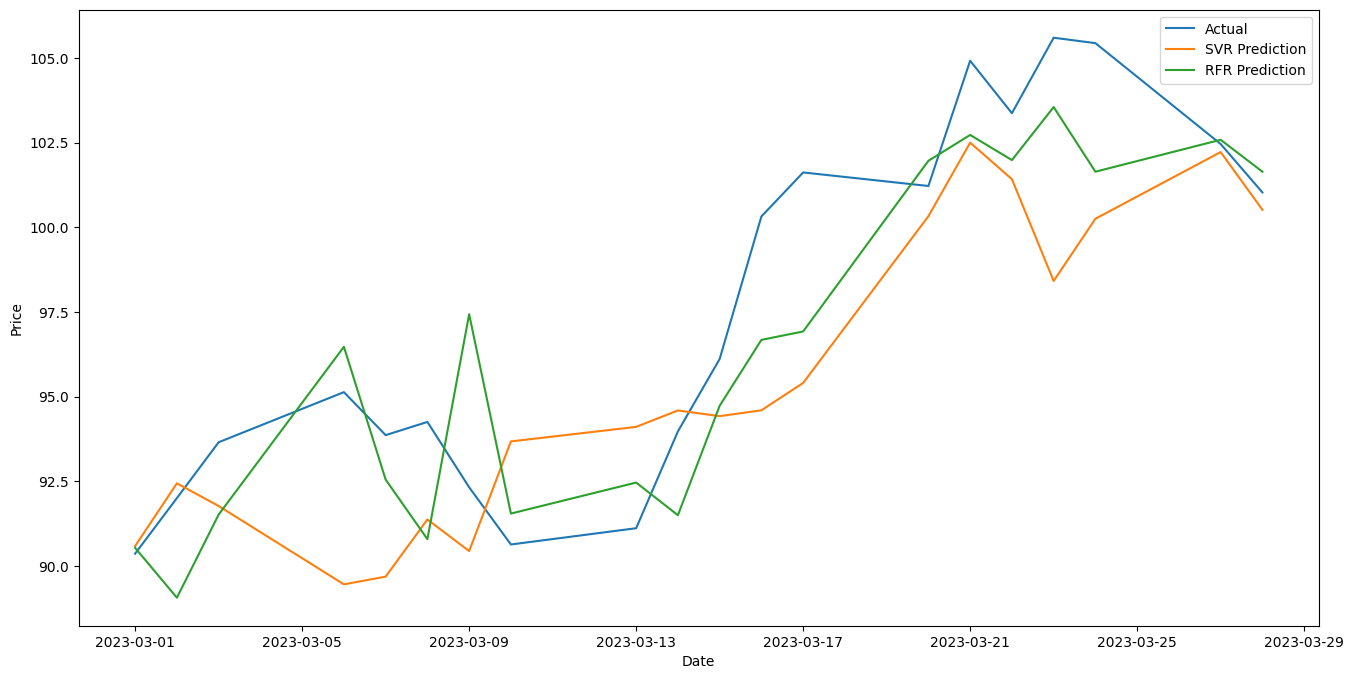

In [8]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_with_const, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_with_const, y_train)


evaluate_train_test(X_train_with_const, X_test_with_const)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_with_const)
y_rfr_pred = rfr_model.predict(X_pred_with_const)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


It makes RFR model slightly bad, but the SVR is slightly better. 

## Add PCA

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.965624 │    0.690928 │      16.6461  │      118.915 │      2.75058  │      8.64265 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995527 │    0.687282 │       2.16603 │      120.318 │      0.992996 │      9.29562 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.548808 │        12.3787 │        2.79209 │
├─────────┼───────────────┼────

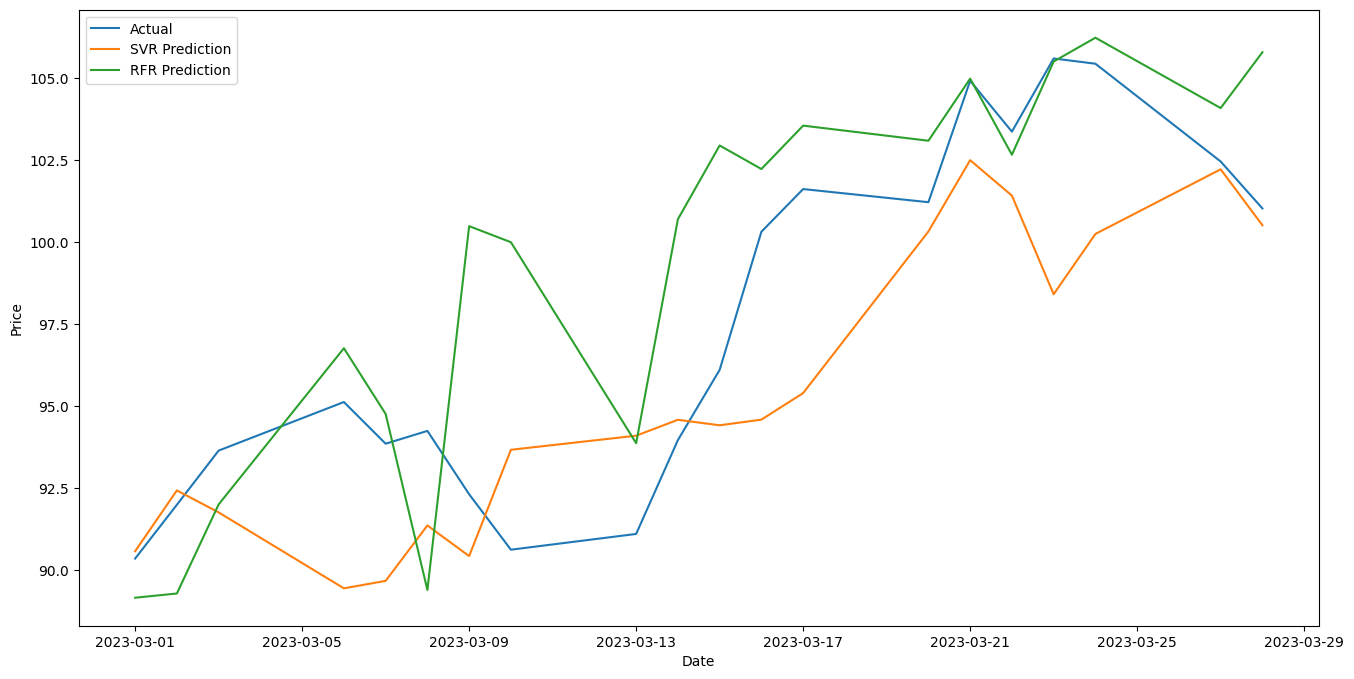

In [9]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Initialize the PCA model:
pca_model = PCA(n_components=6)

# Fit the PCA model to the training data:
pca_model.fit(X_train_with_const)
X_train_pca = pca_model.transform(X_train_with_const)
X_test_pca = pca_model.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_pca, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
rfr_model.fit(X_train_pca, y_train)

evaluate_train_test(X_train_pca, X_test_pca)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_pca = pca_model.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_pca)
y_rfr_pred = rfr_model.predict(X_pred_pca)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


After using PCA, it makes RFR model become worse. For SVR, the model has become slightly bad compare with previous. 

## Add PolynomialFeatures

╒═════════╤══════════════╤═════════════╤═══════════════╤══════════════╤═══════════════╤══════════════╕
│ Model   │   R² (Train) │   R² (Test) │   MSE (Train) │   MSE (Test) │   MAE (Train) │   MAE (Test) │
╞═════════╪══════════════╪═════════════╪═══════════════╪══════════════╪═══════════════╪══════════════╡
│ SVR     │     0.96585  │    0.690284 │      16.5369  │      119.163 │       2.7439  │      8.68446 │
├─────────┼──────────────┼─────────────┼───────────────┼──────────────┼───────────────┼──────────────┤
│ RFR     │     0.995335 │    0.720833 │       2.25906 │      107.409 │       1.00417 │      8.80416 │
╘═════════╧══════════════╧═════════════╧═══════════════╧══════════════╧═══════════════╧══════════════╛
╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.59014  │       11.2447  │        2.65322 │
├─────────┼───────────────┼────

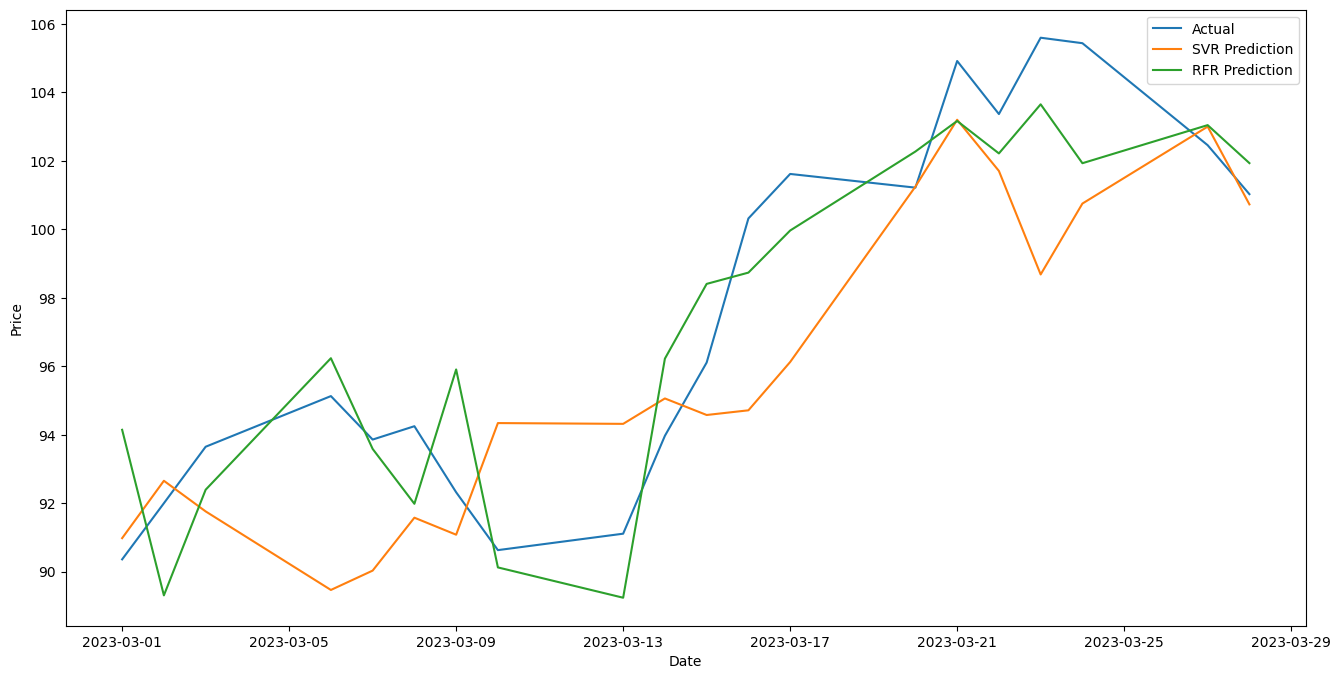

In [10]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=10, gamma='auto')
svr_model.fit(X_train_poly, y_train)

# # Build RFR model
rfr_model = RandomForestRegressor(
    n_estimators=50, random_state=10)
rfr_model.fit(X_train_poly, y_train)

evaluate_train_test(X_train_poly, X_test_poly)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)
y_rfr_pred = rfr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

RFR models has been doing well right now. However, SVR still need to perform extra techinque.

## Add Features by using Technical Indicators 

SVR only. since RFR do very well aldy.

In [11]:
# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Build SVR model
svr_model = SVR(kernel='linear', C=100, gamma='auto')
svr_model.fit(X_train_poly, y_train)

SVR(C=100, gamma='auto', kernel='linear')

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.664969 │        9.19175 │        2.49802 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.845886 │        4.22819 │        1.80161 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


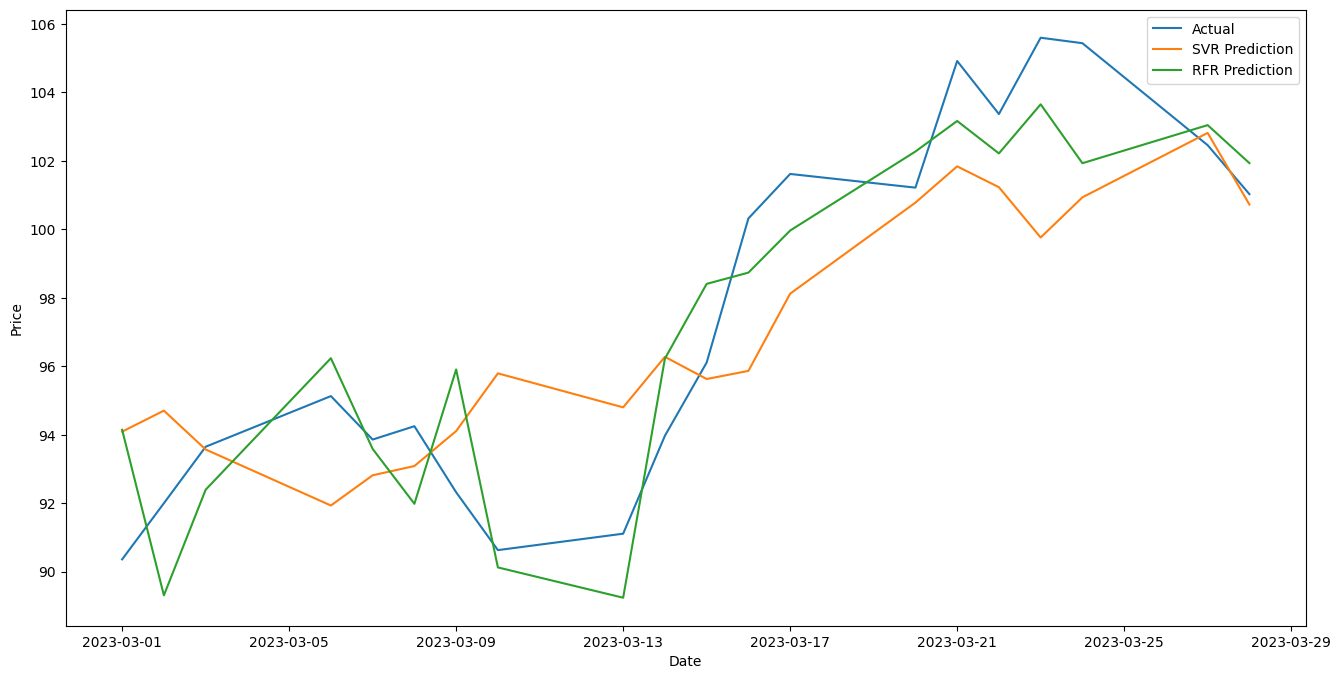

In [12]:
# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Apply GridSearchCV

RFR Model

In [13]:
# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Create a GridSearchCV object with the parameter grid and the Random Forest Regressor model
grid_search_rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=10),
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

# Fit the GridSearchCV object to the training data
grid_search_rfr.fit(X_train_poly, y_train)

# Get the best model
rfr_model = grid_search_rfr.best_estimator_

# # Build RFR model
# rfr_model = RandomForestRegressor(n_estimators=100, random_state=10)
# rfr_model.fit(X_train_poly, y_train)

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_rfr_pred = rfr_model.predict(X_pred_poly)


In [14]:
grid_search_rfr.best_params_


{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 100}

SVR model

In [15]:
# Define the parameter grid
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 2, 6)),
    'degree': [2, 3, 4],
    'coef0': [-1, 0, 1]
}

# Download historical price data from Yahoo Finance and store in a pandas DataFrame
df = yf.download("GOOGL", start='2015-03-01', end='2023-03-01', progress=False)

# Add technical indicators
# Simple Moving Average (SMA)
df['SMA_10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()

# Exponential Moving Average (EMA)
df['EMA_10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()

# Relative Strength Index (RSI)
df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=10).rsi()

# Average True Range (ATR)
df['ATR'] = ta.volatility.AverageTrueRange(
    df['High'], df['Low'], df['Close'], window=14)

# Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(df['Close'], window_slow=26,
                     window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_Signal'] = macd.macd_signal()

# Create a new column for the dependent variable
df['PriceAfterMonth'] = df['Close'].shift(-20)

# Remove rows with missing values
df.dropna(inplace=True)

# Define the independent and dependent variables
X = df.drop('PriceAfterMonth', axis=1)
y = df['PriceAfterMonth']

# Perform feature selection by selecting features with a correlation coefficient of at least 0.5 with the target variable
corr = X.corrwith(y)
corr_threshold = 0.5
selected_features = corr[abs(corr) > corr_threshold].index.tolist()
X = X[selected_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10, shuffle=False)

# Preprocess the data by scaling it
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Fit the SVR model with a constant term
X_train_with_const = np.c_[X_train, np.ones(X_train.shape[0])]
X_test_with_const = np.c_[X_test, np.ones(X_test.shape[0])]

# Apply PolynomialFeatures to the data
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_with_const)
X_test_poly = poly.transform(X_test_with_const)

# Create the GridSearchCV object
svr_grid_svr = GridSearchCV(SVR(), param_grid, cv=5,
                        scoring='neg_mean_squared_error')

# Fit the GridSearchCV object to the training data
svr_grid_svr.fit(X_train_poly, y_train)

# Get the best model
svr_model = svr_grid_svr.best_estimator_

# Download latest historical price data from Yahoo Finance and store in a pandas DataFrame
df_actual = yf.download(
    "GOOGL", start='2023-03-01', end='2023-03-29', progress=False)

# Get the last 30 days of historical data
number_of_days = len(df_actual)
last_n_days = df[-number_of_days:]

last_n_days_df = pd.DataFrame(
    last_n_days, columns=X.columns)

X_pred = scaler.transform(last_n_days_df)
X_pred_with_const = np.c_[X_pred, np.ones(X_pred.shape[0])]
X_pred_poly = poly.transform(X_pred_with_const)

# Make predictions for the next 30 days using the SVR & RFR model
y_svr_pred = svr_model.predict(X_pred_poly)

Evaluate SVR & RFR Performance

╒═════════╤═══════════════╤════════════════╤════════════════╕
│ Model   │   R² (Actual) │   MSE (Actual) │   MAE (Actual) │
╞═════════╪═══════════════╪════════════════╪════════════════╡
│ SVR     │      0.67175  │        9.00571 │        2.47629 │
├─────────┼───────────────┼────────────────┼────────────────┤
│ RFR     │      0.868012 │        3.62115 │        1.72214 │
╘═════════╧═══════════════╧════════════════╧════════════════╛


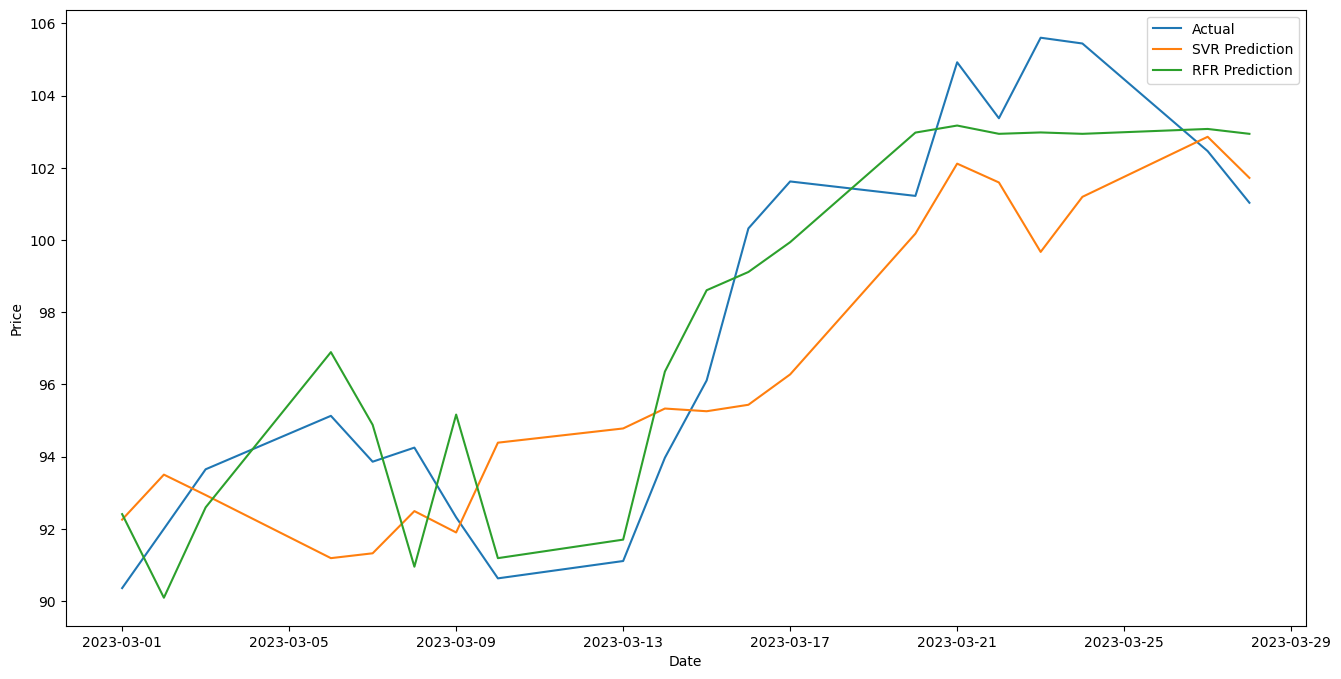

In [16]:
# Add the predictions to the actual data in a new DataFrame
df_pred = pd.DataFrame({'SVR Prediction': y_svr_pred,
                        'RFR Prediction': y_rfr_pred}, index=df_actual.index)

df_combined = pd.concat([df_actual, df_pred], axis=1)

# Calculate evaluation metrics for SVR model
r2_svr_actual = r2_score(
    df_combined['Close'], df_combined['SVR Prediction'])
mse_svr_actual = mean_squared_error(
    df_combined['Close'], df_combined['SVR Prediction'])
mae_svr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['SVR Prediction'])

# Calculate evaluation metrics for RFR model
r2_rfr_actual = r2_score(
    df_combined['Close'], df_combined['RFR Prediction'])
mse_rfr_actual = mean_squared_error(
    df_combined['Close'], df_combined['RFR Prediction'])
mae_rfr_actual = mean_absolute_error(
    df_combined['Close'], df_combined['RFR Prediction'])

# Create a table to display the evaluation metrics for both SVR and RFR models
table = [["Model", "R² (Actual)", "MSE (Actual)", "MAE (Actual)"],
         ["SVR", r2_svr_actual, mse_svr_actual, mae_svr_actual],
         ["RFR", r2_rfr_actual, mse_rfr_actual, mae_rfr_actual]]
print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

# Plot the actual price and the predictions
plt.figure(figsize=(16, 8))
plt.plot(df_combined.index, df_combined['Close'], label='Actual')
plt.plot(df_combined.index,
         df_combined['SVR Prediction'], label='SVR Prediction')
plt.plot(df_combined.index,
         df_combined['RFR Prediction'], label='RFR Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()